<a href="https://colab.research.google.com/github/aikozvezda/Simulation-GRWM/blob/main/Simulation_GRWM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **전체 작업을 하는 데 필요한 모델, 라이브러 및 패키지들**

In [82]:
!pip install opencv-python dlib
!pip install mediapipe
!pip install opencv-python-headless

import cv2
import numpy as np
import io
import dlib
import mediapipe as mp
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from PIL import Image
from google.colab import files


In [83]:
from google.colab import files
uploaded = files.upload()

Saving shape_predictor_68_face_landmarks.dat.bz2 to shape_predictor_68_face_landmarks.dat (1).bz2


In [ ]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -d shape_predictor_68_face_landmarks.dat.bz2

# MobileNet SSD 모델 파일 다운로드
!wget -O deploy.prototxt https://github.com/chuanqi305/MobileNet-SSD/raw/master/deploy.prototxt
!wget -O mobilenet_iter_73000.caffemodel https://github.com/chuanqi305/MobileNet-SSD/raw/master/mobilenet_iter_73000.caffemodel

--2024-06-02 12:00:08--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2.5’

shape_predictor_68_ 100%[===================>]  61.07M   119MB/s    in 0.5s    

2024-06-02 12:00:09 (119 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2.5’ saved [64040097/64040097]

bzip2: Output file shape_predictor_68_face_landmarks.dat already exists.
--2024-06-02 12:00:09--  https://github.com/chuanqi305/MobileNet-SSD/raw/master/deploy.prototxt
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/chuanqi305/MobileNet-SSD/master/deploy.prototxt [following]
--2024-06-02 12:00:09--  https://raw.git

In [81]:
from google.colab import files

# 사용자에게 배경 이미지를 업로드하도록 요청
print("카페, 클럽, 바다, 숲 배경 이미지를 업로드하세요 (카페: cafe.webp, 클럽: club.webp, 바다: ocean.webp, 숲: forest.webp):")
uploaded = files.upload()

# 업로드된 파일 확인
for file_name in uploaded.keys():
    print(f'Uploaded file: {file_name}')


카페, 클럽, 바다, 숲 배경 이미지를 업로드하세요 (카페: cafe.webp, 클럽: club.webp, 바다: ocean.webp, 숲: forest.webp):


Saving 슬라이드3.PNG to 슬라이드3 (2).PNG
Uploaded file: 슬라이드3 (2).PNG


**웹캠을 통해 사진을 촬영하고, 얼굴 랜드마크를 감지하여 주요 특징과 머리 윤곽선을 시각화하는 기능 수행**

<IPython.core.display.Javascript object>

Saved to face.jpg


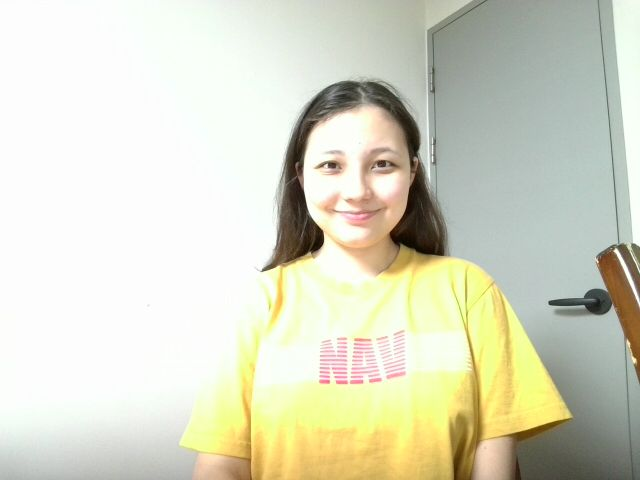

In [ ]:
def take_photo(filename='face.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});
            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            // Resize the output to fit the video element.
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            // Wait for Capture to be clicked.
            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getTracks().forEach(track => track.stop());
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

# Capture a photo and save it.
filename = take_photo()
print('Saved to {}'.format(filename))

# Display the photo.
img = Image.open(filename)
display(img)

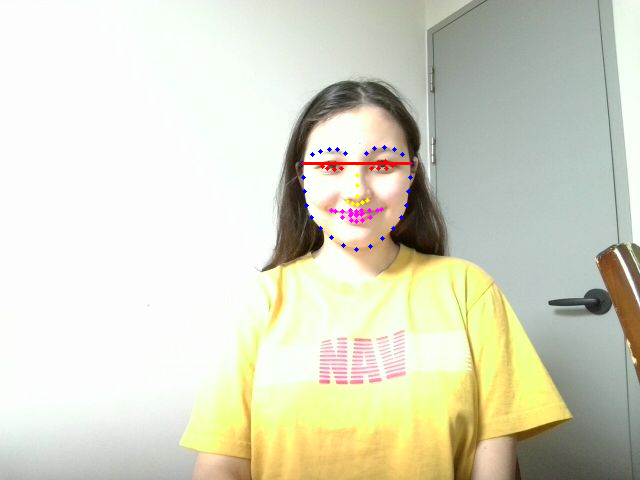

In [ ]:
# Dlib의 얼굴 인식기와 랜드마크 탐지기 불러오기
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

# 캡처된 이미지 읽기
face_img = cv2.imread('face.jpg')
gray = cv2.cvtColor(face_img, cv2.COLOR_BGR2GRAY)

# 얼굴 감지
faces = detector(gray)

for face in faces:
    x1 = face.left()
    y1 = face.top()
    x2 = face.right()
    y2 = face.bottom()

    # 얼굴 랜드마크 감지
    landmarks = predictor(gray, face)

    # 얼굴 윤곽선 그리기
    for i in range(0, 68):
        x = landmarks.part(i).x
        y = landmarks.part(i).y
        cv2.circle(face_img, (x, y), 2, (255, 0, 0), -1)

    # 눈, 코, 입을 각각 인식하고 표시
    for i in range(36, 42):  # 왼쪽 눈
        x = landmarks.part(i).x
        y = landmarks.part(i).y
        cv2.circle(face_img, (x, y), 2, (0, 0, 255), -1)

    for i in range(42, 48):  # 오른쪽 눈
        x = landmarks.part(i).x
        y = landmarks.part(i).y
        cv2.circle(face_img, (x, y), 2, (0, 0, 255), -1)

    for i in range(27, 36):  # 코
        x = landmarks.part(i).x
        y = landmarks.part(i).y
        cv2.circle(face_img, (x, y), 2, (0, 255, 255), -1)

    for i in range(48, 68):  # 입
        x = landmarks.part(i).x
        y = landmarks.part(i).y
        cv2.circle(face_img, (x, y), 2, (255, 0, 255), -1)

    # 머리 윤곽선을 위한 좌우와 상하의 경계 계산
    left_x = landmarks.part(0).x
    right_x = landmarks.part(16).x
    top_y = min([landmarks.part(i).y for i in range(17)])
    bottom_y = y2  # 얼굴의 최하단은 감지된 얼굴 영역의 y2를 사용

    # 빨간색 선: 머리의 좌우 경계
    cv2.line(face_img, (left_x, top_y), (right_x, top_y), (0, 0, 255), 2)

# 결과 출력
cv2_imshow(face_img)

**다음 2가지 머리 스타일을 다운 받아서 다음 코드에 업로드 하세요. **

[긴생머리]https://drive.google.com/file/d/17xlnLWuPar6Lqojf3aH5nNyrSV2MXXBI/view?usp=sharing

[긴웨이브머리]https://drive.google.com/file/d/1DHGn76KKFzp0T_RdeMIIj3XAaTHlF6n7/view?usp=drive_link

얼굴 좌우 경계의 길이: 218 픽셀
헤어스타일 이미지를 업로드하세요:


Saving 슬라이드3.PNG to 슬라이드3 (1).PNG
업로드된 헤어스타일 이미지: 슬라이드3 (1).PNG


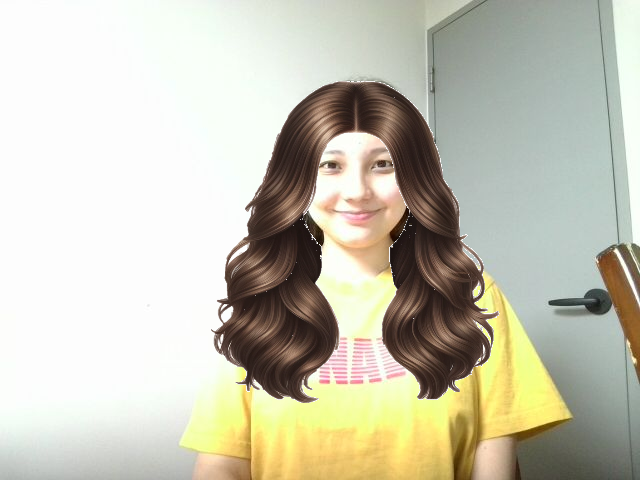

최종 합성 이미지가 'final_result.png'로 저장되었습니다.


In [ ]:
# Dlib의 얼굴 인식기와 랜드마크 탐지기 불러오기
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

# 1. 얼굴 이미지 처리 및 좌우 경계 계산
# 얼굴 이미지 읽기
face_img_path = 'face.jpg'  # 실제 얼굴 이미지 경로
face_img = cv2.imread(face_img_path)
gray = cv2.cvtColor(face_img, cv2.COLOR_BGR2GRAY)

# 얼굴 감지
faces = detector(gray)

if len(faces) == 0:
    raise Exception("No faces detected in the image")

for face in faces:
    # 얼굴 랜드마크 감지
    landmarks = predictor(gray, face)

    # 얼굴 윤곽선 길이 측정 (좌측 끝에서 우측 끝까지의 거리)
    left_x = landmarks.part(0).x
    right_x = landmarks.part(16).x
    width = 2 * (right_x - left_x)
    print(f"얼굴 좌우 경계의 길이: {width} 픽셀")

    # 이마의 y 좌표 계산
    top_y = min([landmarks.part(i).y for i in range(17)])
    bottom_y = landmarks.part(8).y

# 2. 머리카락 이미지 처리 및 갈색 부분 추출
# 헤어스타일 이미지 업로드
print("헤어스타일 이미지를 업로드하세요:")
uploaded = files.upload()

# 업로드된 헤어스타일 이미지 파일명 가져오기
hair_img_name = list(uploaded.keys())[0]
print(f"업로드된 헤어스타일 이미지: {hair_img_name}")

# 헤어스타일 이미지 읽기
hair_img = cv2.imread(hair_img_name, cv2.IMREAD_UNCHANGED)
if hair_img is None:
    raise Exception("헤어스타일 이미지를 불러오지 못했습니다.")

# 알파 채널이 없는 경우 추가
if hair_img.shape[2] == 3:
    hair_img = cv2.cvtColor(hair_img, cv2.COLOR_BGR2BGRA)

# BGR 이미지에서 갈색 계열의 범위를 설정 (HSV 범위)
lower_brown = np.array([0, 10, 0], dtype=np.uint8)  # 갈색의 하한값
upper_brown = np.array([40, 255, 255], dtype=np.uint8)  # 갈색의 상한값

# BGR 이미지를 HSV 이미지로 변환
hsv_img = cv2.cvtColor(hair_img[:, :, :3], cv2.COLOR_BGR2HSV)

# 갈색 범위에 해당하는 마스크 생성
mask = cv2.inRange(hsv_img, lower_brown, upper_brown)

# 마스크를 이용해 갈색 부분만 남기고 나머지 부분을 투명하게 만들기
result_img = hair_img.copy()
result_img[:, :, 3] = mask  # 알파 채널을 마스크로 설정

# 3. 갈색 부분만 남긴 머리카락 이미지를 얼굴 좌우 경계에 맞춰 크기 조절
# 얼굴 윤곽선의 길이에 맞게 머리카락 이미지 크기 조절
hair_img_resized = cv2.resize(result_img, (int(width * 1.5), int(result_img.shape[0] * (width * 1.5 / result_img.shape[1]))))

# 4. 머리카락 이미지를 얼굴 이미지에 합성
# 얼굴 이미지를 BGRA 포맷으로 변환
face_img_bgra = cv2.cvtColor(face_img, cv2.COLOR_BGR2BGRA)

# 머리카락 이미지를 얼굴 이미지에 합성
# y_offset을 조정하여 머리카락을 더 아래로 내리도록 설정
y_offset = top_y - hair_img_resized.shape[0] // 3  # 머리카락을 더 아래로 이동
x_offset = left_x - (hair_img_resized.shape[1] - width) // 1
for i in range(hair_img_resized.shape[0]):
    for j in range(hair_img_resized.shape[1]):
        if hair_img_resized[i, j][3] != 0:  # alpha 값이 0이 아닌 픽셀만 복사
            if 0 <= y_offset + i < face_img_bgra.shape[0] and 0 <= x_offset + j < face_img_bgra.shape[1]:
                face_img_bgra[y_offset + i, x_offset + j] = hair_img_resized[i, j]

# 결과 이미지 출력 및 저장
cv2_imshow(face_img_bgra)
cv2.imwrite('final_result.png', face_img_bgra)
print("최종 합성 이미지가 'final_result.png'로 저장되었습니다.")

입술에 적용할 색상을 선택하세요 (red/pink): red


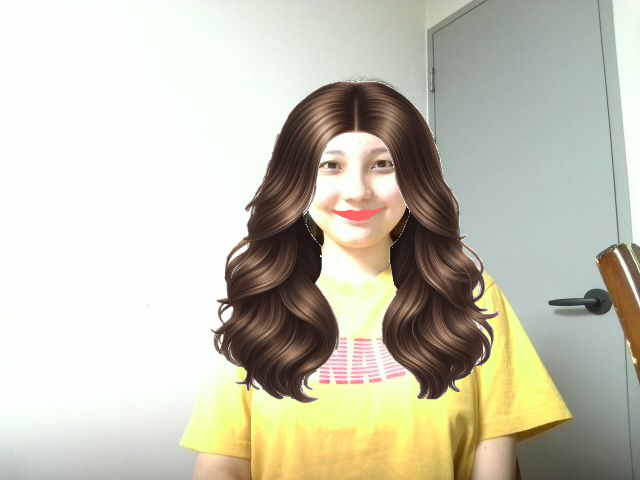

최종 합성 이미지가 'final_result_with_lipstick.png'로 저장되었습니다.


In [ ]:
# Dlib의 얼굴 인식기와 랜드마크 탐지기 불러오기
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

# 1. 합성된 이미지 읽기
face_img = cv2.imread('final_result.png')
gray = cv2.cvtColor(face_img, cv2.COLOR_BGR2GRAY)

# 얼굴 감지
faces = detector(gray)

if len(faces) == 0:
    raise Exception("No faces detected in the image")

for face in faces:
    # 얼굴 랜드마크 감지
    landmarks = predictor(gray, face)

    # 입술 영역 마스크 생성
    lips_points = []
    for i in range(48, 60):  # 외곽 입술
        x = landmarks.part(i).x
        y = landmarks.part(i).y
        lips_points.append((x, y))
    for i in range(60, 68):  # 내부 입술
        x = landmarks.part(i).x
        y = landmarks.part(i).y
        lips_points.append((x, y))

    lips_points = np.array(lips_points, dtype=np.int32)

    # 색상 선택
    color_choice = input("입술에 적용할 색상을 선택하세요 (red/pink): ").strip().lower()
    if color_choice == "red":
        lip_color = (102, 102, 255)  # 빨간색
    elif color_choice == "pink":
        lip_color = (102, 51, 204)  # 핑크색
    else:
        raise ValueError("Invalid color choice. Please select 'red' or 'pink'.")

    # 입술 부분에 색상 적용
    cv2.fillPoly(face_img, [lips_points[:12]], lip_color)
    cv2.fillPoly(face_img, [lips_points[12:]], lip_color)

# 결과 이미지 출력 및 저장
cv2_imshow(face_img)
cv2.imwrite('final_result_with_lipstick.png', face_img)
print("최종 합성 이미지가 'final_result_with_lipstick.png'로 저장되었습니다.")


눈에 적용할 렌즈 색상을 선택하세요 (gray/black/brown/green): brown


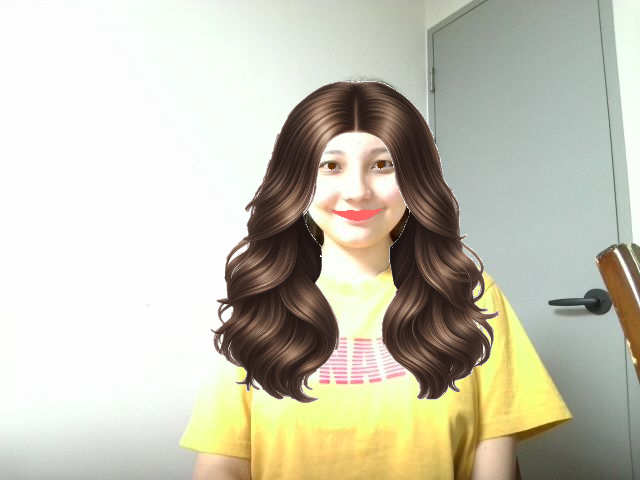

최종 합성 이미지가 'final_result_with_lipstick_and_lenses.png'로 저장되었습니다.


In [ ]:
# Dlib의 얼굴 인식기와 랜드마크 탐지기 불러오기
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

# 1. 합성된 이미지 읽기
face_img = cv2.imread('final_result_with_lipstick.png')  # 입술 색상이 적용된 이미지를 사용
gray = cv2.cvtColor(face_img, cv2.COLOR_BGR2GRAY)

# 얼굴 감지
faces = detector(gray)

if len(faces) == 0:
    raise Exception("No faces detected in the image")

for face in faces:
    # 얼굴 랜드마크 감지
    landmarks = predictor(gray, face)

    # 렌즈 색상 선택
    lens_color_choice = input("눈에 적용할 렌즈 색상을 선택하세요 (gray/black/brown/green): ").strip().lower()
    if lens_color_choice == "gray":
        lens_color = (102, 102, 102)
    elif lens_color_choice == "black":
        lens_color = (0, 0, 0)
    elif lens_color_choice == "brown":
        lens_color = (0, 51, 102)
    elif lens_color_choice == "green":
        lens_color = (51, 102, 51)
    else:
        raise ValueError("Invalid lens color choice. Please select 'gray', 'black', 'brown', or 'green'.")

    # 눈동자 영역 마스크 생성 및 색상 적용
    left_eye_center = np.mean([(landmarks.part(i).x, landmarks.part(i).y) for i in range(36, 42)], axis=0).astype(int)
    right_eye_center = np.mean([(landmarks.part(i).x, landmarks.part(i).y) for i in range(42, 48)], axis=0).astype(int)

    # 눈동자 크기 설정 (반지름)
    iris_radius = 3

    # 왼쪽 눈동자 색상 적용
    cv2.circle(face_img, tuple(left_eye_center), iris_radius, lens_color, -1)
    # 오른쪽 눈동자 색상 적용
    cv2.circle(face_img, tuple(right_eye_center), iris_radius, lens_color, -1)

# 결과 이미지 출력 및 저장
cv2_imshow(face_img)
cv2.imwrite('final_result_with_lipstick_and_lenses.png', face_img)
print("최종 합성 이미지가 'final_result_with_lipstick_and_lenses.png'로 저장되었습니다.")

/usr/local/lib/python3.10/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


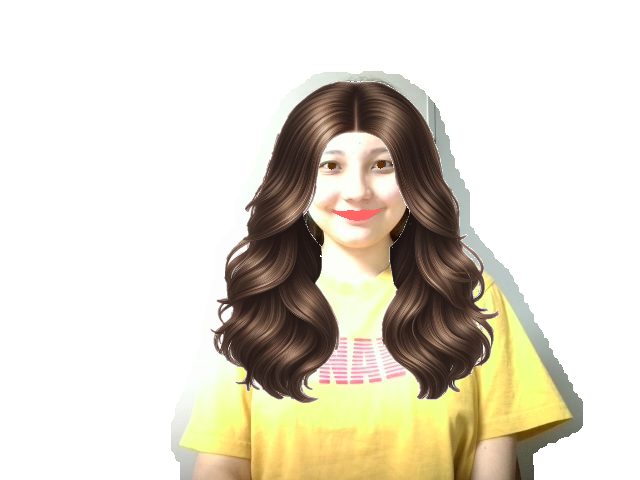

배경이 제거된 이미지가 'full_body_without_background.png'로 저장되었습니다.


In [ ]:
# MediaPipe Pose 모델 초기화
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True, model_complexity=2, enable_segmentation=True, min_detection_confidence=0.5)

# 이미지 로드
img = cv2.imread('final_result_with_lipstick_and_lenses.png')
if img is None:
    raise FileNotFoundError("Could not load the image")

# 이미지 크기 가져오기
h, w = img.shape[:2]

# 이미지를 RGB로 변환
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Pose Detection 수행
results = pose.process(img_rgb)

mask = np.zeros((h, w), dtype=np.uint8)

if results.segmentation_mask is not None:
    # 세그멘테이션 마스크 가져오기
    segmentation_mask = results.segmentation_mask
    segmentation_mask = np.stack((segmentation_mask,) * 3, axis=-1) > 0.1
    segmentation_mask = segmentation_mask.astype(np.uint8) * 255

    # 마스크 확장
    kernel = np.ones((10, 10), np.uint8)
    mask = cv2.dilate(segmentation_mask[:, :, 0], kernel, iterations=2)

# 원본 이미지를 BGRA로 변환
img_bgra = cv2.cvtColor(img, cv2.COLOR_BGR2BGRA)

# 마스크를 사용하여 배경을 제거 (투명하게 만들기)
for c in range(0, 3):
    img_bgra[:, :, c] = cv2.bitwise_and(img_bgra[:, :, c], img_bgra[:, :, c], mask=mask)
img_bgra[:, :, 3] = mask

# 결과 이미지 출력 및 저장
cv2_imshow(img_bgra)
cv2.imwrite('full_body_without_background.png', img_bgra)
print("배경이 제거된 이미지가 'full_body_without_background.png'로 저장되었습니다.")

어디에 가고 싶어요? (cafe, club, ocean, forest): cafe


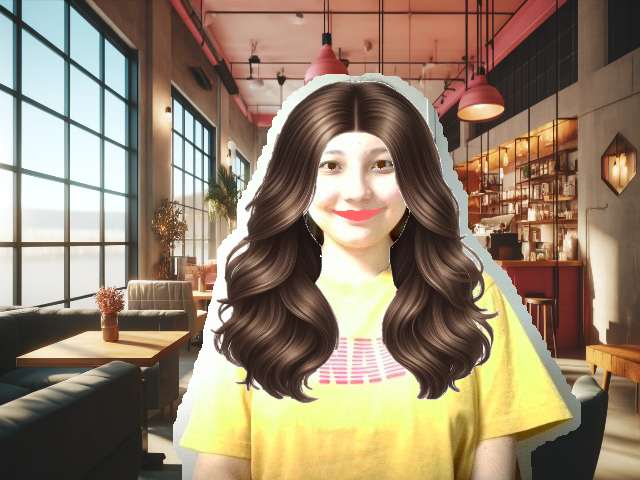

배경이 변경된 이미지가 'cafe_result.png'로 저장되었습니다.


In [ ]:


# MediaPipe Pose 모델 초기화
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True, model_complexity=2, enable_segmentation=True, min_detection_confidence=0.5)

# 이미지 로드
img = cv2.imread('final_result_with_lipstick_and_lenses.png')
if img is None:
    raise FileNotFoundError("Could not load the image")

# 이미지 크기 가져오기
h, w = img.shape[:2]

# 이미지를 RGB로 변환
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Pose Detection 수행
results = pose.process(img_rgb)

mask = np.zeros((h, w), dtype=np.uint8)

if results.segmentation_mask is not None:
    # 세그멘테이션 마스크 가져오기
    segmentation_mask = results.segmentation_mask
    segmentation_mask = np.stack((segmentation_mask,) * 3, axis=-1) > 0.1
    segmentation_mask = segmentation_mask.astype(np.uint8) * 255

    # 마스크 확장 및 축소
    kernel_expand = np.ones((10, 10), np.uint8)
    kernel_shrink = np.ones((5, 5), np.uint8)
    mask = cv2.dilate(segmentation_mask[:, :, 0], kernel_expand, iterations=2)
    mask = cv2.erode(mask, kernel_shrink, iterations=1)

# 원본 이미지를 BGRA로 변환
img_bgra = cv2.cvtColor(img, cv2.COLOR_BGR2BGRA)

# 마스크를 사용하여 배경을 제거 (투명하게 만들기)
for c in range(0, 3):
    img_bgra[:, :, c] = cv2.bitwise_and(img_bgra[:, :, c], img_bgra[:, :, c], mask=mask)
img_bgra[:, :, 3] = mask

# 사용자에게 배경 선택 옵션 제공
background_options = {'cafe': 'cafe.webp', 'club': 'club.webp', 'ocean': 'ocean.webp', 'forest': 'forest.webp'}
selected_background = input("어디에 가고 싶어요? (cafe, club, ocean, forest): ")

if selected_background in background_options:
    # 선택한 배경 이미지 로드
    background_image = cv2.imread(background_options[selected_background], cv2.IMREAD_UNCHANGED)
    background_image = cv2.resize(background_image, (w, h))

    # 배경 이미지의 채널 수 확인
    if background_image.shape[2] == 3:
        background_image = cv2.cvtColor(background_image, cv2.COLOR_BGR2BGRA)

    # 배경 이미지와 사람 이미지 합성
    result = np.zeros((h, w, 4), dtype=np.uint8)
    for c in range(0, 3):
        result[:, :, c] = np.where(img_bgra[:, :, 3] > 0, img_bgra[:, :, c], background_image[:, :, c])
    result[:, :, 3] = np.where(img_bgra[:, :, 3] > 0, 255, background_image[:, :, 3])

    # 결과 이미지 출력 및 저장
    cv2_imshow(result)
    cv2.imwrite(f'{selected_background}_result.png', result)
    print(f"배경이 변경된 이미지가 '{selected_background}_result.png'로 저장되었습니다.")
else:
    print("잘못된 배경 선택입니다.")